Datset on New York in 2013 found at: https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls

### Data

The data used in this investigation is the 2013 Crime Rates in New York City. We're using the variables with information on crime to predict whether Murder has occured in each city. 

### Preprocessing

After cleaning the data, we changed the murder column to binary values where 1 means that murder has occured and 0 that it hasn't.

### Feature Selection

In this model we're using each of the features available to us by the columns of data. Furthermore, we created a new column for Population squared to put a higher emphasis on population. This is also done to provide more quadratic 'noise' to our model for the sake of showing how regularization can minimize the overfitting affects of large data and large coefficients.

In [1]:
import math

from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import scipy
import statsmodels.formula.api as smf
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action='ignore', module='scipy', message='^internal gelsd')

In [2]:
# Read data using pandas
df = pd.read_excel('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls')

# Delete first three rows
df = df.drop([0,1,2], axis=0)

# Make first row the column headers
df = df.reset_index(drop=True)
df.columns = df.iloc[0]
df = df.drop([0], axis=0)
df = df.reset_index(drop=True)

# Rename all column headers
df.columns = ['City', 'Population', 'Violent Crime', 'Murder and Nonnegligent Manslaughter', 'Rape (revised definition)', 'Rape (legacy definition)', 'Robbery', 'Aggravated Assault', 'Property Crime', 'Burglary', 'Larceny-Theft', 'Motor Vehicle Theft', 'Arson']

# Remove entire Unnamed: 4 or 'Rape revised defintion'
df = df.drop('Rape (revised definition)', axis=1)

# Remove null objects
df = df.drop([348, 349, 350], axis=0)
df = df.drop('Arson', axis=1)
df = df.dropna(how='all')

# Convert all columns from object to integer values
df[['Population', 'Violent Crime',
       'Murder and Nonnegligent Manslaughter', 'Rape (legacy definition)',
       'Robbery', 'Aggravated Assault', 'Property Crime', 'Burglary',
       'Larceny-Theft', 'Motor Vehicle Theft']] = df[['Population', 'Violent Crime',
       'Murder and Nonnegligent Manslaughter', 'Rape (legacy definition)',
       'Robbery', 'Aggravated Assault', 'Property Crime', 'Burglary',
       'Larceny-Theft', 'Motor Vehicle Theft']].astype(int)

# Remove New York and buffalo from data because it skews the data. Although the data is correct
df[df['City'] == 'New York']
df = df[(df['City']!='New York')&(df['City']!='Buffalo')]

# Change name of Property Crime so that it's one word
df['Propertycrime'] = df['Property Crime']
df = df.drop(columns=['Property Crime'])

df['Murder'] = df['Murder and Nonnegligent Manslaughter']
df = df.drop(columns=['Murder and Nonnegligent Manslaughter'])

df['Aggravated_Assault'] = df['Aggravated Assault']
df = df.drop(columns=['Aggravated Assault'])

In [3]:
# Create Features: Population^2, Murder binary, Robbery, binary
# More specifically, create binary categories for murder and robery
df['Population^2'] = df['Population']**2
df['Murder'] = np.where(df['Murder']>0, '1', '0')
#df['Aggravated_Assault'] = np.where(df['Aggravated_Assault']>0, '1', '0')

#Convert new columns to int
df[['Population^2']] = df[['Population^2']].astype(int)
df[['Murder']] = df[['Murder']].astype(int)
df[['Aggravated_Assault']] = df[['Aggravated_Assault']].astype(int)

In [4]:
df.corr()

,Population,Violent Crime,Rape (legacy definition),Robbery,Burglary,Larceny-Theft,Motor Vehicle Theft,Propertycrime,Murder,Aggravated_Assault,Population^2
Population,1.000,0.796,0.737,0.778,0.767,0.871,0.804,0.857,0.505,0.799,0.881
Violent Crime,0.796,1.000,0.922,0.988,0.945,0.875,0.973,0.912,0.453,0.994,0.869
Rape (legacy definition),0.737,0.922,1.000,0.893,0.950,0.885,0.917,0.918,0.442,0.915,0.776
Robbery,0.778,0.988,0.893,1.000,0.932,0.853,0.975,0.893,0.417,0.965,0.878
Burglary,0.767,0.945,0.950,0.932,1.000,0.929,0.959,0.964,0.430,0.931,0.793
Larceny-Theft,0.871,0.875,0.885,0.853,0.929,1.000,0.890,0.994,0.472,0.871,0.799
Motor Vehicle Theft,0.804,0.973,0.917,0.975,0.959,0.890,1.000,0.928,0.407,0.954,0.875
Propertycrime,0.857,0.912,0.918,0.893,0.964,0.994,0.928,1.000,0.466,0.905,0.816
Murder,0.505,0.453,0.442,0.417,0.430,0.472,0.407,0.466,1.000,0.469,0.355
Aggravated_Assault,0.799,0.994,0.915,0.965,0.931,0.871,0.954,0.905,0.469,1.000,0.852


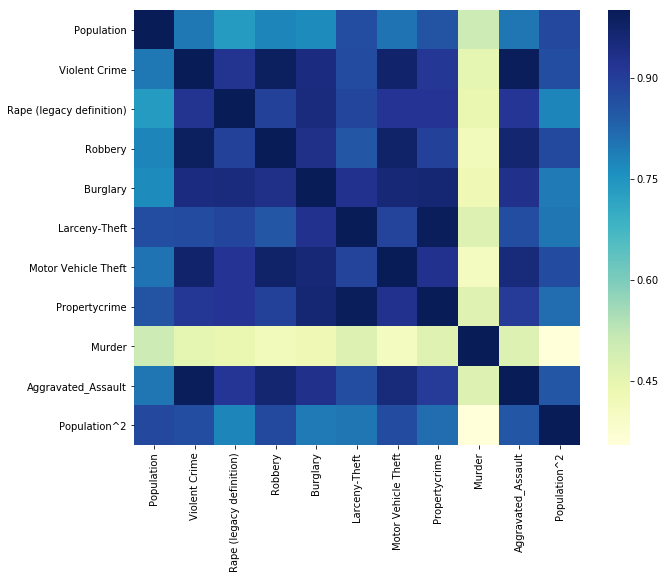

In [22]:
plt.subplots(figsize=(10,8))
sns.heatmap((df.corr()), cmap='YlGnBu')

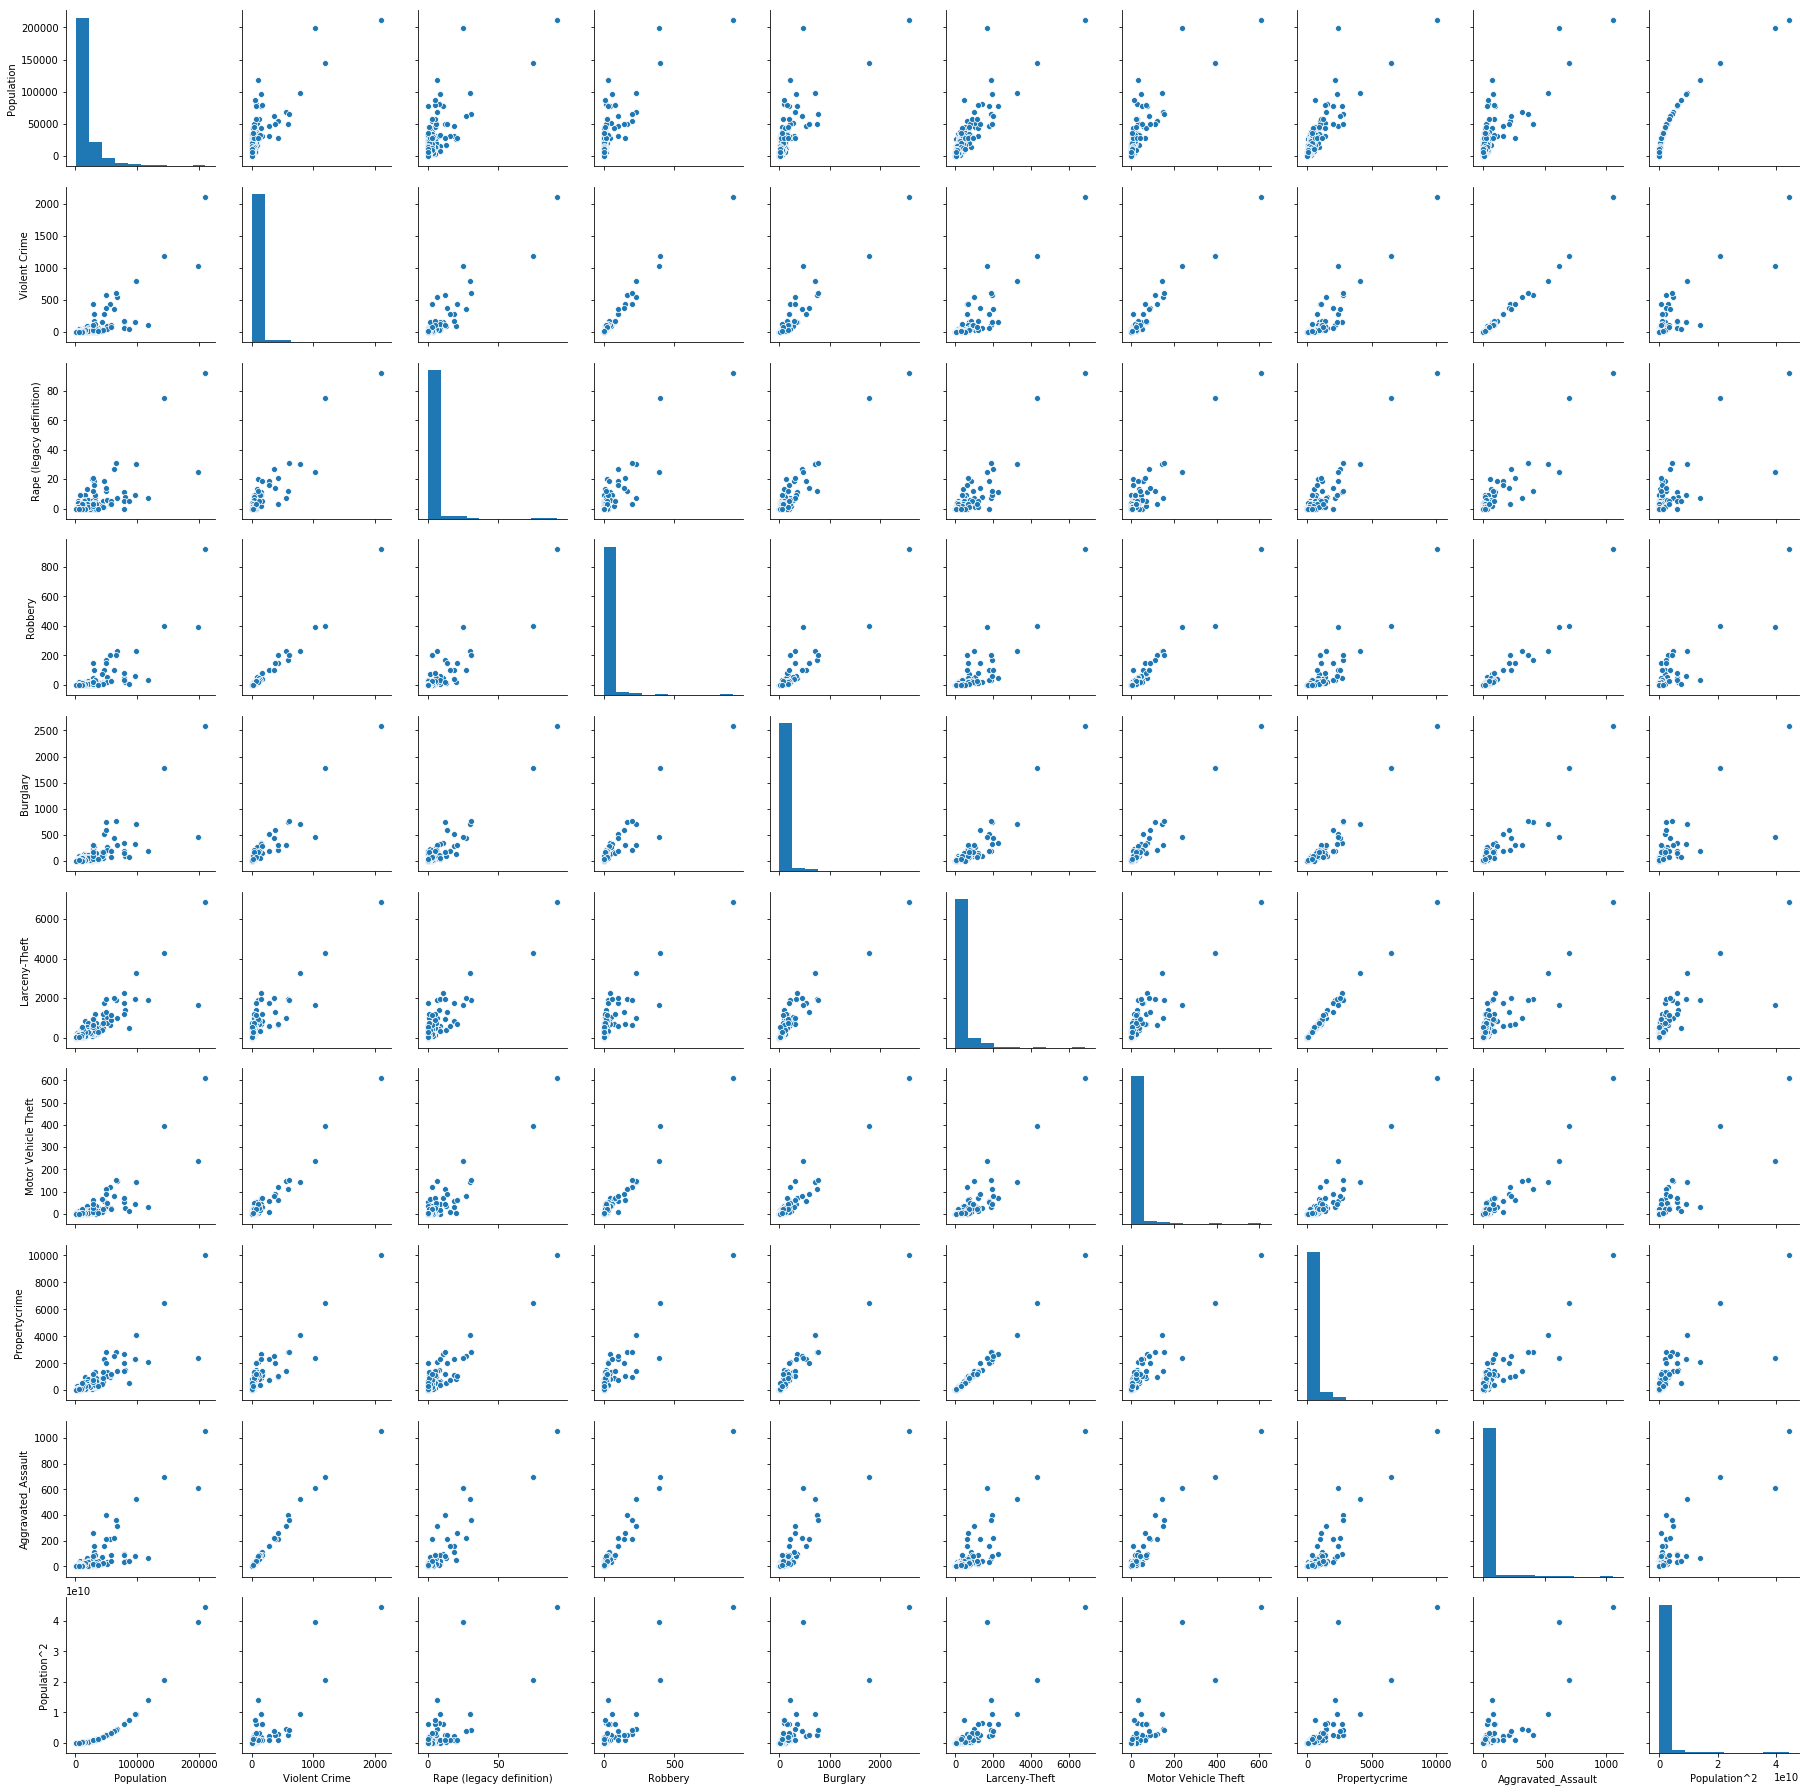

In [27]:
# Engineer Features at least 15 features

sns.pairplot(df.drop(columns=['Murder']))

In [64]:
df1 = df[df['Violent Crime']<50]

In [65]:
df1.head()

,Population,Violent Crime,Rape (legacy definition),Robbery,Burglary,Larceny-Theft,Motor Vehicle Theft,Propertycrime,Murder,Aggravated_Assault,Population^2
0,1861,0,0,0,2,10,0,12,0,0,3463321
1,2577,3,0,0,3,20,1,24,0,3,6640929
2,2846,3,0,0,1,15,0,16,0,3,8099716
4,6388,23,3,4,53,165,5,223,0,16,40806544
5,4089,5,0,3,10,36,0,46,0,2,16719921


In [66]:
# Problems to solve with predictors in this data
# 1. All variables have distributions that are highly positively skewedd to due to extremely low medians
# 2. All variables are are highly correlated with one another
# 3. All variables have many outliers

# Logistic Regression

In [7]:
# Logist Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

logreg = LogisticRegression()
logregl2 = LogisticRegression(penalty='l2')
logregl1 = LogisticRegression(penalty='l1')

x = df.drop(['City', 'Murder'], 1)
y = df['Murder']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

logreg.fit(x_train, y_train)

y_pred = logreg.predict(x_test)

print('Accuracy of Logistic Regression Model for predicting Murder in New York = ' + str(logreg.score(x_test, y_test)))


KeyError: "['City'] not found in axis"

In [ ]:
# Confusion Matrix to view errors
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

In [ ]:
# Compute precision, recall, F-mearue and support
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# L2 (Ridge) Logistic Regression

In [ ]:
logregl2.fit(x_train, y_train)

y_pred = logregl2.predict(x_test)

print('Accuracy of Logistic Regression Model for predicting Murder in New York = ' + str(logregl2.score(x_test, y_test)))

In [ ]:
# Confusion Matrix to view errors
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

In [ ]:
# Compute precision, recall, F-mearue and support
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# L1 (Lasso) Logistic Regression

In [ ]:
logregl1.fit(x_train, y_train)

y_pred = logregl1.predict(x_test)

print('Accuracy of Logistic Regression Model for predicting Murder in New York = ' + str(logregl1.score(x_test, y_test)))

In [ ]:
# Confusion Matrix to view errors
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

In [ ]:
# Compute precision, recall, F-mearue and support
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

### Observations

In the models above we've combined logistic regression with regularization by tuning the parameter to penalties like L1 and L2 repressenting lasso and ridge regularization.

Regular Logistic Regression and Ridge Regression gives the same level of accuracy when classifying Murder at 88%.

Lasso regression improves the model by 4 percent to 92%.

# Ridge Regression

In [ ]:
from sklearn import linear_model

ridge = linear_model.Ridge(alpha=1, fit_intercept=False)

x = df.drop(['City', 'Murder'], 1)
y = df['Murder']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)
print(ridge.score(x_test, y_test))

# Lasso Regression

In [ ]:
from sklearn import linear_model

lasso = linear_model.Lasso(alpha=1.5)

x = df.drop(['City', 'Murder'], 1)
y = df['Murder']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

lasso.fit(x_train, y_train)
y_pred = lasso.predict(x_test)
print(lasso.score(x_test, y_test))

# Ridge and Lasso Observations

Neither the Ridge nor Lasso regressions have show promising models for classifying Murder. The R squared value for the Ridge regression is negative, indicating the value wasn't squared because the model was so poor. Further more, the lasso regression has a model accuracy of 38%. Changing the lambda value doesn't improve either model by much.

# Final Conclusions

Logistic Regression coupled with tuning the parameters to Lasso regression provides the most accurate model at 92% and so is the best by far. Furthermore, the the logistic L1 regression also has consistent precision, recall scores at 92% and F-score rates at 91%. This shows us that the models ability to predict true positive values are quite strong.

However, even logistic regression isn't the best predictor of this model. The variables of this model have multicollinearity and there aren't many columns with large data point that would encourage using ridge or lasso regression. Because of the multicollinearity, adding new variables that are quaratic or cubic might multiply the overfitting that's already occuring. Therefore, a different model, may be more appropriate.